In [1]:
from pathlib import Path

from dataset import ImageDataset

dataset = ImageDataset(Path("data_col_public/"))

In [2]:
len(dataset)

4700

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Resize(600, 420),
        A.RandomCrop(512, 384),  # 4x3
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.2),
        A.Normalize(normalization="min_max"),
        ToTensorV2(),
    ],
    additional_targets={"rgb_image": "image"},
)

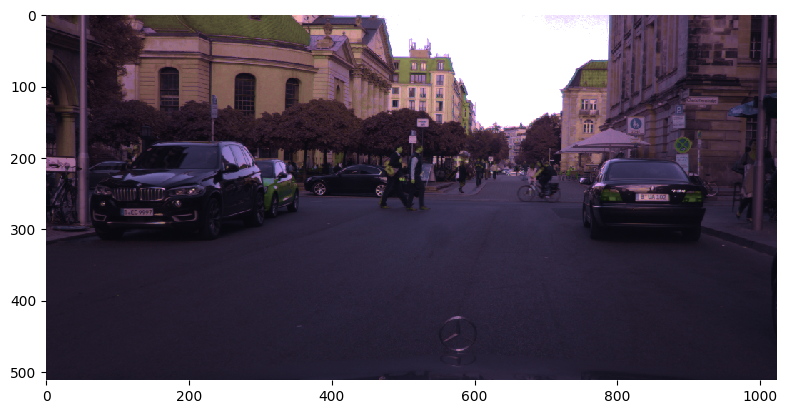

In [4]:
import matplotlib.pyplot as plt


def ishow(
    img, cmap="viridis", title="", fig_size=(8, 6), colorbar=False, interpolation="none"
):
    "Function `ishow` displays an image in a new window."

    # extent = (0, img.shape[1], img.shape[0], 0)
    img = img.permute(1, 2, 0).cpu().detach().numpy()
    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.imshow(
        img,
        # extent=extent,
        cmap=cmap,
        interpolation=interpolation,
    )

    ax.set_frame_on(False)
    plt.title(title)
    plt.tight_layout()
    if colorbar:
        fig.colorbar(pcm, orientation="vertical")
    plt.show()


ishow(dataset[0][1])

In [5]:
def show_augmentations(ds, idx, n_samples=3):
    figure = plt.figure(figsize=(12, 8))

    rows = n_samples
    cols = 2

    for i in range(1, rows + 1):
        gray, rgb = ds[idx]

        gray_np = gray.permute(1, 2, 0).cpu().detach().numpy()
        rgb_np = rgb.permute(1, 2, 0).cpu().detach().numpy()

        if gray_np.min() < 0 or gray_np.max() > 1:
            print(
                f"The image values were shifted to the range (0, 1). The original range is ({gray_np.min():.04f}, {gray_np.max():.04f})"
            )
            gray_np = (gray_np - gray_np.min()) / (gray_np.max() - gray_np.min())
            rgb_np = (rgb_np - rgb_np.min()) / (rgb_np.max() - rgb_np.min())

        figure.add_subplot(rows, cols, i * 2 - 1)
        plt.axis("off")
        plt.imshow(
            gray_np, cmap="gray"
        )  # if you don't use cmap="gray", matplotlib will use viridis

        figure.add_subplot(rows, cols, i * 2)
        plt.axis("off")
        plt.imshow(rgb_np)

    plt.suptitle(f"Sample No {idx}")
    plt.tight_layout()
    plt.show()


In [6]:
dataset = ImageDataset(Path("data_col_public/"), train_transform)

The image values were shifted to the range (0, 1). The original range is (-0.0000, 1.0000)
The image values were shifted to the range (0, 1). The original range is (-0.0000, 1.0000)


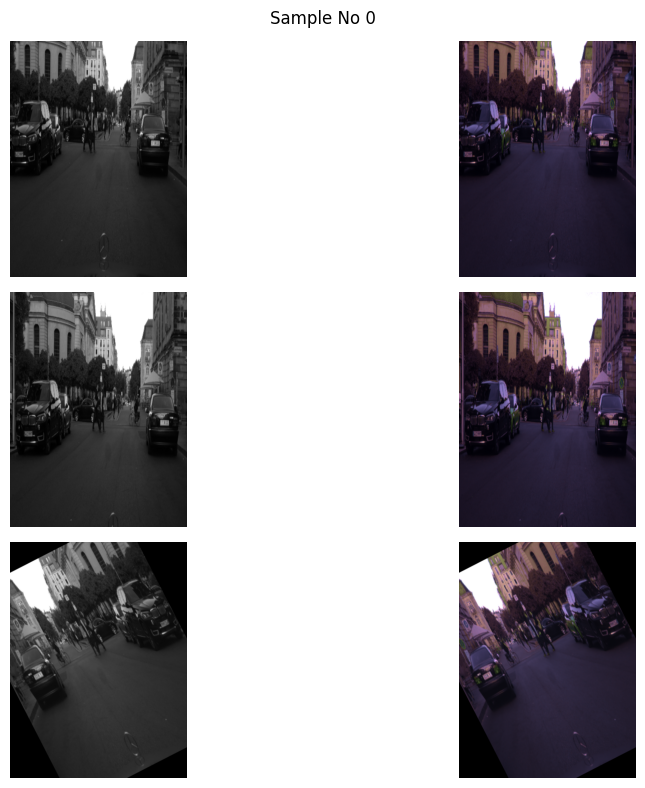

In [7]:
show_augmentations(dataset, 0)

In [ ]:
from network import DownBlock, Generator

x = dataset[0][0]

d1 = DownBlock(1, 64, False)
d2 = DownBlock(64, 64)
d3 = DownBlock(64, 128)
d4 = DownBlock(128, 256)
d5 = DownBlock(256, 512)


In [9]:
x = x.unsqueeze(0)

In [10]:
x.shape

torch.Size([1, 1, 512, 384])

In [11]:
gen = Generator()
gen(x)

num of skips: 7


In [25]:
ds = DownSampler()

In [26]:
x = ds(x)

In [27]:
x.shape

torch.Size([1, 512, 8, 6])

In [ ]:
import torch
from torch import Tensor, nn


class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU

        down_filters = [1, 64, 64, 128, 256, 256, 512]
        use_batch_norm = [False, False, True, True, True, True, False]

        self.down_layers = nn.ModuleList(
            [
                DownBlock(down_filters[i], down_filters[i + 1], use_batch_norm[i + 1])
                for i in range(len(down_filters) - 1)
            ]
        )

        bottleneck_out_channels = 512
        self.bottleneck = DownBlock(down_filters[-1], bottleneck_out_channels, False)

        self.up_layers = nn.ModuleList()
        up_filters = [512, 256, 256, 128, 64, 64]

        in_channels = bottleneck_out_channels
        for i in range(len(up_filters)):
            out_channels = up_filters[i]
            if i > 0:
                in_channels *= 2
            self.up_layers.append(UpBlock(in_channels, out_channels, i < 3))
            in_channels = up_filters[i]

        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=down_filters[-1],
                out_channels=3,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.Tanh(),
        )

    def forward(self, x: Tensor) -> Tensor:
        skip_connections = []

        for down_layer in self.down_layers:
            x = down_layer(x)
            skip_connections.append(x)

        x = self.bottleneck(x)

        for i in range(len(self.up_layers)):
            x = self.up_layers[i](x, skip_connections[len(self.up_layers) - i - 1])

        return x


class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: ...


class DownBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, batch_norm: bool = True
    ) -> None:
        super().__init__()
        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        ]

        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        self.downsample = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        return self.downsample(x)


class UpBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, use_dropout: bool = True
    ) -> None:
        super().__init__()

        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

        if use_dropout:
            self.upsample.append(nn.Dropout2d(0.5))

    def forward(self, x: Tensor, residual_x: Tensor) -> Tensor:
        x = self.upsample(x)
        return torch.cat([x, residual_x], dim=1)


In [152]:
g.down_layers

ModuleList(
  (0): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (3): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [153]:
g = Generator()
g(x).shape

torch.Size([1, 64, 256, 192])
torch.Size([1, 64, 128, 96])
torch.Size([1, 128, 64, 48])
torch.Size([1, 256, 32, 24])
torch.Size([1, 256, 16, 12])
torch.Size([1, 512, 8, 6])
OOOOOOOOOOOOOOOOOOOOOO
torch.Size([1, 1024, 8, 6])
torch.Size([1, 512, 16, 12])
torch.Size([1, 512, 32, 24])
torch.Size([1, 256, 64, 48])
torch.Size([1, 128, 128, 96])
torch.Size([1, 128, 256, 192])


torch.Size([1, 128, 256, 192])

In [54]:
a = [1, 2, 3, 4, 5]
list(reversed(a[:-1]))

[4, 3, 2, 1]